In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc
from code.generate_data import SinteticData
from code.representation import *
from code.utils import *
from code.baseline import RaykarMC
from code.MixtureofGroups import GroupMixtureOpt

Using TensorFlow backend.


CIFAR example 50k exaples, 10 classes


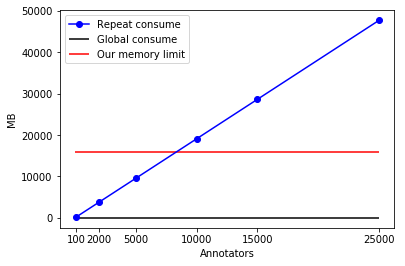

In [52]:
memory_cons = []
to_check = [100,2000,5000,10000,15000,25000]
N = 50000
K = 10
for t in to_check:
    a = np.zeros((N,t,K),dtype='float32') #int8
    memory_cons.append(a.nbytes/(1024*1024)) #MB

ours_consume = np.zeros((N,K),dtype='float32').nbytes/(1024*1024)
print("CIFAR example 50k exaples, 10 classes")
plt.plot(to_check,memory_cons,'bo-',label="Repeat consume")
plt.hlines(ours_consume,0,25000, label="Global consume")
plt.hlines(16000,0,25000, color='r', label="Our memory limit")

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("Annotators")
plt.legend()
plt.show()

In [2]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

GenerateData = SinteticData(state=None)

#CONFUSION MATRIX CHOOSE
GenerateData.set_probas(asfile=True,file_matrix='./synthetic/simple/matrix_datasim_normal.csv',file_groups ='./synthetic/simple/groups_datasim_normal.csv')

#GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

In [3]:
to_check = [100,2000,5000,10000,15000,25000,40000]
T_data = 10 

annot_acc = []
raykar_exec = []
raykar_init = []
ourglobal_exec = []
ourglobal_init = []
for Tmax in to_check:
    
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=True)

    annot_acc.append(np.mean(GenerateData.yo_label == Z_train))

    #get representation needed for Raykar
    y_obs_categorical = set_representation(y_obs,'onehot') 

    raykarMC = RaykarMC(X_train.shape[1:],y_obs_categorical.shape[-1],Tmax,epochs=1)
    raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)
    logL_hists,i = raykarMC.multiples_run(1,X_train,y_obs_categorical,max_iter=2)
    
    raykar_exec.append(raykarMC.current_exectime)
    raykar_init.append(raykarMC.init_exectime)
    

    r_obs = set_representation(y_obs,"repeat")

    gMixture_Global = GroupMixtureOpt(X_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=1,pre_init=0) 
    gMixture_Global.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture_Global.lambda_random = True #with lambda random --necessary
    logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,max_iter=2,cluster=True)
    
    ourglobal_exec.append(gMixture_Global.current_exectime)
    ourglobal_init.append(gMixture_Global.init_exectime)
    
    del y_obs,groups_annot, y_obs_categorical,raykarMC,r_obs,gMixture_Global
    gc.collect()
raykar_exec = np.asarray(raykar_exec)
raykar_init = np.asarray(raykar_init)
ourglobal_exec = np.asarray(ourglobal_exec)
ourglobal_init = np.asarray(ourglobal_init)
print("Done")

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: done,  E step: done //  (in 0.80 sec)	logL: -18987.006	
Iter 2/2 
M step: done,  E step: done //  (in 0.10 sec)	logL: -17690.441	Tol1: 0.06829	Tol2: 0.26662	
Finished training
Epochs to converge=  2.0
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.002664 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9668011  0.12903388 0.16277824 0.24980631 0.12833413]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 0.67 sec)	logL: -26713.708	
Iter 2/2
M step: done,  E step: done //  (in 0.11 sec)	logL: -24986.007	Tol1: 0.06467	Tol2: 0.60647	Tol3: 0.15541	
Finished training!
Epochs to converge=  2.0
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estima

In [ ]:
#our cluster time... 0.0021*60

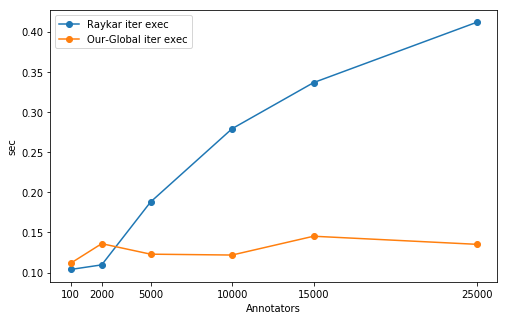

In [24]:
plt.figure(figsize=(8,5))
plt.plot(to_check,raykar_exec,'o-',label="Raykar iter exec")
plt.plot(to_check,ourglobal_exec,'o-',label="Our-Global iter exec")
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

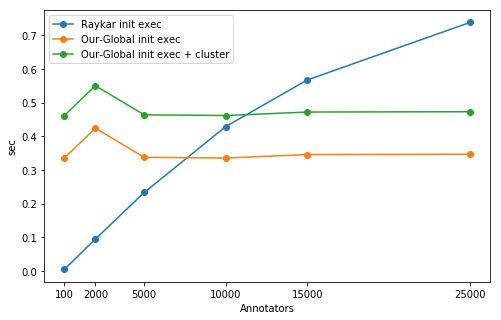

In [25]:
plt.figure(figsize=(8,5))
plt.plot(to_check,raykar_init,'o-',label="Raykar init exec")
plt.plot(to_check,ourglobal_init,'o-',label="Our-Global init exec")
plt.plot(to_check,ourglobal_init+0.0021*60,'o-',label="Our-Global init exec + cluster")
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

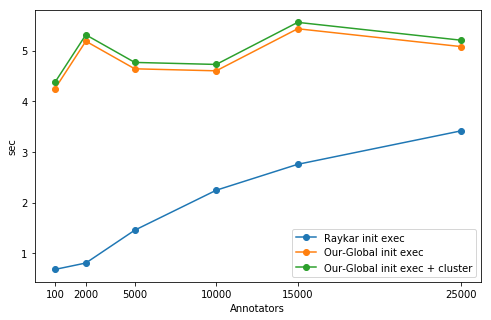

In [27]:
# falta por el numero de iteraciones (El nuestro tiene mas)
R_iter = 6.5
Our_iter = 35

plt.figure(figsize=(8,5))
plt.plot(to_check,raykar_init+raykar_exec*R_iter,'o-',label="Raykar init exec")
plt.plot(to_check,ourglobal_init+ourglobal_exec*Our_iter,'o-',label="Our-Global init exec")
plt.plot(to_check,ourglobal_init+0.0021*60+ourglobal_exec*Our_iter,'o-',label="Our-Global init exec + cluster")
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

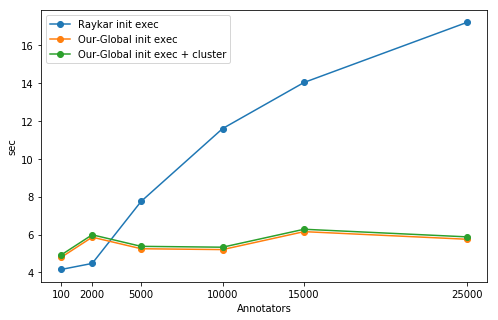

In [26]:
# falta por el numero de iteraciones (El nuestro tiene mas)
R_iter = 40
Our_iter = 40

plt.figure(figsize=(8,5))
plt.plot(to_check,raykar_init+raykar_exec*R_iter,'o-',label="Raykar init exec")
plt.plot(to_check,ourglobal_init+ourglobal_exec*Our_iter,'o-',label="Our-Global init exec")
plt.plot(to_check,ourglobal_init+0.0021*60+ourglobal_exec*Our_iter,'o-',label="Our-Global init exec + cluster")
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()